In [2]:
#needed for the random forest application
import numpy as np
from matplotlib import pyplot as plt
import sklearn.cross_validation as xval
from sklearn.ensemble import RandomForestClassifier
import forestci as fci
from sklearn.datasets import make_classification

/mypath/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#create fake data set
X, y = make_classification(5000)
xtrain, xtest, ytrain, ytest  = xval.train_test_split(X, y, test_size = 0.2)

In [4]:
#build forest and calculate inbag matrix and raw prediction matrix
ntree = 500
RFC = RandomForestClassifier(max_features=5, n_estimators=ntree, random_state=42)
RFC.fit(xtrain, ytrain)
yhat = RFC.predict_proba(xtest)
inbag = fci.calc_inbag(xtrain.shape[0], RFC)
pred = np.array([tree.predict(xtest) for tree in RFC]).T

In [5]:
#import things necessary for R and python integration
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas.rpy.common as com
import pandas as pd

/mypath/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html


In [6]:
#send inbag and pred to R as matrices and run a R function on them
ro.globalenv['inbag'] = com.convert_to_r_matrix(pd.DataFrame(inbag))
ro.globalenv['pred'] = com.convert_to_r_matrix(pd.DataFrame(pred))
results = ro.r('randomForestCI::infJack(pred, inbag, calibrate=TRUE)')

In [7]:
#bring results back to python
df = com.convert_robj(results)
df['y'] = ytest
df['sd'] = np.sqrt(df['var.hat'])

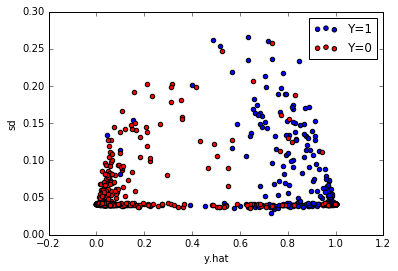

In [8]:
#plot results
%matplotlib inline

ax = df[df.y==1].plot.scatter(y='sd', x= 'y.hat', label = 'Y=1', color = 'Blue')
df[df.y==0].plot.scatter(y='sd', x= 'y.hat',  label = 'Y=0', color = 'Red', ax = ax)